In [1]:
import os
import sys

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import brier_score_loss, log_loss
from sklearn.calibration import calibration_curve, CalibrationDisplay

sys.path.append('../')

from utils import load_atp_data

In [2]:
def kelly_winner_bet(row):
    
    base = row['model_w_pred']
    sub = (1 - base) / (row['psw'] - 1)
    
    return base - sub

def kelly_loser_bet(row):
    
    base = row['model_l_pred']
    sub = (1 - base) / (row['psl'] - 1)
    
    return base -sub

In [3]:
# loading all atp data
df = load_atp_data('../tennis_atp')

shape before dropping match dupes: (583792, 75)
shape after dropping match dupes: (583731, 75)


In [10]:
# loading the data with model predictions
oof_df = pd.read_csv("../data/prediction_df.csv", parse_dates=['player_tourney_date'])

In [11]:
# loading the betting data 
years = ['2021.xlsx', '2022.xlsx', '2023.xlsx']

folder = '../tennis_betting_data/'

betting_df = pd.DataFrame()

for year in years:
    df_ = pd.read_excel(f'{folder}{year}')
    betting_df = pd.concat([betting_df, df_])
    
betting_df['date_monday'] = betting_df['Date'] - pd.offsets.Week(weekday=0)
betting_df['winner_last_name'] = [x.split()[0] for x in betting_df.Winner]
betting_df['loser_last_name'] = [x.split()[0] for x in betting_df.Loser]

betting_df.drop(columns='Surface', inplace=True)

In [12]:
# creating a list->tuple of the players in each match
# we'll use these tuples to merge the dataframes 
# this shouldnt be necessary but i foolishly messed up the
# indices in the model df
unique_match_players = df[['winner_id', 'loser_id']].values.tolist()
df['details'] = unique_match_players
df['details'] = [tuple(sorted(x)) for x in df['details']]

unique_match_players_oof = oof_df[['player_id', 'player_2_id']].values.tolist()
oof_df['details'] = unique_match_players_oof
oof_df['details'] = [tuple(sorted(x)) for x in oof_df['details']]

# creating the assessment df by merging the two
assess_df = (
    oof_df
    .merge(df, how='left', left_on=['player_tourney_date', 'details'],
           right_on=['tourney_date', 'details'])
)

# indicating when player_id in oof_df matches winner
assess_df['player_one_winner'] = np.where(assess_df['player_id'] == assess_df['winner_id'], 1, 0)
assess_df['winner_last_name'] = [x.split()[-1] for x in assess_df.winner_name]
assess_df['loser_last_name'] = [x.split()[-1] for x in assess_df.loser_name]

In [13]:
# creating the trial dataframe to test our model

trial = assess_df.merge(betting_df, how='left', left_on=['tourney_date', 'winner_last_name', 'loser_last_name'],
                 right_on=['date_monday', 'winner_last_name', 'loser_last_name'])

trial = trial[~trial['date_monday'].isnull()]
trial.columns = trial.columns.str.lower()

# calculating odds with and without vigorish for the average price
trial['avg_vegas_pred_w'] = 1 / trial['avgw']
trial['avg_vegas_pred_l'] = 1 / trial['avgl']
trial['avg_overround'] = trial[['avg_vegas_pred_w', 'avg_vegas_pred_l']].sum(axis=1)
trial['avg_w_no_vig'] = trial['avg_vegas_pred_w'].div(trial['avg_overround'])
trial['avg_l_no_vig'] = trial['avg_vegas_pred_l'].div(trial['avg_overround'])

# calculating odds with and without vigorish for pinnacle
trial['pinnacle_vegas_pred_w'] = 1 / trial['psw']
trial['pinnacle_vegas_pred_l'] = 1 / trial['psl']
trial['pinnacle_overround'] = trial[['pinnacle_vegas_pred_w', 'pinnacle_vegas_pred_l']].sum(axis=1)
trial['pinnacle_w_no_vig'] = trial['pinnacle_vegas_pred_w'].div(trial['pinnacle_overround'])
trial['pinnacle_l_no_vig'] = trial['pinnacle_vegas_pred_l'].div(trial['pinnacle_overround'])

# converting the model predictions to winner and loser predictions
trial['model_w_pred'] = np.where(trial['player_one_winner'] == 1,
                                 trial['pred_player_one_win'],
                                 1 - trial['pred_player_one_win'])

trial['model_l_pred'] = 1 - trial['model_w_pred']

# calculating kelly bet given predictions
trial['winner_kelly_bet'] = trial.apply(kelly_winner_bet, axis=1)
trial['loser_kelly_bet'] = trial.apply(kelly_loser_bet, axis=1)

# dropping all rows where we don't have a vegas prediction
# and eliminating some anomalies
trial = trial[~trial['avg_vegas_pred_w'].isnull()].copy()
trial = trial[~trial['pinnacle_vegas_pred_w'].isnull()].copy()
trial = trial[trial['pinnacle_vegas_pred_w'].between(0, 1)].copy()
trial = trial[trial['avg_overround'].between(1, 1.07)].copy()
trial = trial[trial['pinnacle_overround'].between(1, 1.03)].copy()

print(trial.shape)

(3226, 194)


In [14]:
# to briefly explain whats happening here, the original dataframe
# has a column for winners and losers. above i calculated 
# the vegas and model predictions for the winner, and now
# by randomly assigning 1s and 0s we can calculate log loss 

trial['rearrange'] = np.random.choice([0, 1], size=len(trial))
trial['p1'] = np.where(trial['rearrange'] == 1, trial['pinnacle_vegas_pred_w'], trial['pinnacle_vegas_pred_l'])
trial['p2'] = np.where(trial['rearrange'] == 1, trial['model_w_pred'], trial['model_l_pred'])
trial['p3'] = np.where(trial['rearrange'] == 1, trial['avg_vegas_pred_w'], trial['avg_vegas_pred_l'])

print("the logloss for pinnacle:", log_loss(trial['rearrange'], trial['p1']))
print("the logloss for my model:", log_loss(trial['rearrange'], trial['p2']))
print("the logloss for avg vegas:", log_loss(trial['rearrange'], trial['p3']))

the logloss for pinnacle: 0.5748431265837426
the logloss for my model: 0.5824280598425258
the logloss for avg vegas: 0.5776605832588945


# Comparing Log Loss  

Below I plot the log loss comparisons for the model  
and Pinnacle with different cutoffs. For example,  
when the cutoff is 0.01 it means we're only comparing  
the log loss for matches where the model win probability  
diverged by less than 0.01 from Pinnacle.  

The model is doing very well until about 0.075%.  
When the model diverges by more than that it performs  
relatively poorly. It is worth noticing that Vegas also  
does worse as the divergence increases, suggesting that these  
matches were less predictable.

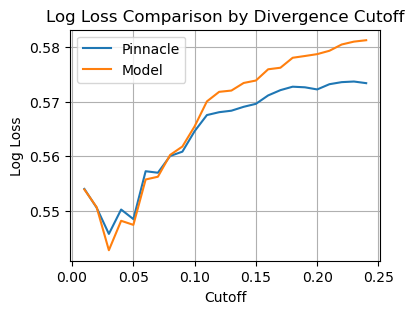

In [70]:
increments = np.arange(0.01, 0.25, 0.01)

ll_vegas = []
ll_model = []

for n in increments:
    filtered_ = trial[trial['abs_diff'] <= n]
    ll_vegas_ = log_loss(filtered_['rearrange'], filtered_['p1'])
    ll_model_ = log_loss(filtered_['rearrange'], filtered_['p2'])
    
    ll_vegas.append(ll_vegas_)
    ll_model.append(ll_model_)
    
fig, ax = plt.subplots(figsize=(4,3))

plt.plot(increments, ll_vegas, label='Pinnacle')
plt.plot(increments, ll_model, label='Model')

plt.title("Log Loss Comparison by Divergence Cutoff")
plt.xlabel("Cutoff")
plt.ylabel("Log Loss")
plt.grid(True)
plt.legend()
plt.show()

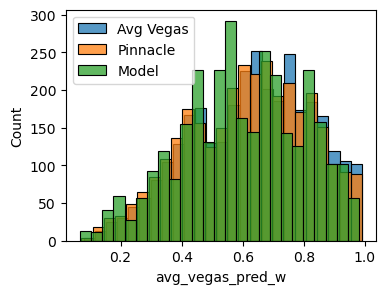

In [15]:
fig, ax = plt.subplots(figsize=(4,3))

sns.histplot(trial['avg_vegas_pred_w'], bins=25, label='Avg Vegas')
sns.histplot(trial['pinnacle_vegas_pred_w'], bins=25, label='Pinnacle')
sns.histplot(trial['model_w_pred'], bins=25, label='Model')

plt.legend()
plt.show()

In [16]:
model_brier = lambda x: brier_score_loss(x['player_one_winner'], x['model_w_pred'])
pinnacle_vegas_brier = lambda x: brier_score_loss(x['player_one_winner'], x['pinnacle_vegas_pred_w'])

briers_df = (
    pd.concat([trial.groupby(['season', 'tourney_name']).apply(model_brier),
               trial.groupby(['season', 'tourney_name']).apply(pinnacle_vegas_brier)], axis=1)
    .rename(columns={0 : 'model', 1 : 'pinnacle'})
)

briers_df['model_wins'] = (briers_df['model'] < briers_df['pinnacle']).astype(int)

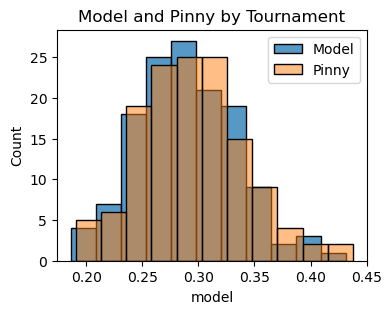

In [17]:
# plotting the performance of the model vs pinny
# across tourneys

fig, ax = plt.subplots(figsize=(4,3))
sns.histplot(briers_df['model'], label='Model')
sns.histplot(briers_df['pinnacle'], label='Pinny', alpha=0.5)

plt.title("Model and Pinny by Tournament")
plt.legend()
plt.show()

# Does a Mixture of Vegas + Model Beat Vegas?  

The answer is yes, as can be seen below. That means  
we're likely on the right track, even if we aren't there yet.  
The model is capturing something useful.  

In [18]:
from sklearn.model_selection import KFold
from sklearn.linear_model import LinearRegression

splitter = KFold(n_splits=100, shuffle=True)

oof = np.zeros(len(trial))

X = trial[['p1', 'p2']]
y = trial['rearrange']

for train, val in splitter.split(X, y):
    
    train_x = X.iloc[train]
    train_y = y.iloc[train]
    
    val_x = X.iloc[val]
    
    model = LinearRegression()
    model.fit(train_x, train_y)
    
    preds = model.predict(val_x)
    oof[val] = preds

print("log loss for vegas only:", log_loss(y, trial['p1']))
print("log loss on the out of fold predictions", log_loss(y, oof))

log loss for vegas only: 0.5748431265837426
log loss on the out of fold predictions 0.5727162014450884


# Bootstrap Resampling  

Bootstrap resampling to estimate SE of log loss for the Pinnacle  
closing line and the model. Here we sample tourney_ids with  
replacement to account for the intra-tournament correlation in  
error from, for example, weather, court conditions, incentives  
invisible to me (home crowd, favorite tournament, critical career  
juncture, etc.)

In [19]:
# doing bootstrap resampling to estimate the mean and standard
# error of our log loss samples. it's likely that errors are correlated,
# so in each iteration we sample a set of tourney ids to compare.
# the standard error converges to 0.008 for vegas and 0.0083 for model

SAMPLES = 250
vegas_losses = []
model_losses = []

for _ in range(SAMPLES):

    tourneys = trial['tourney_id'].sample(55, replace=True)
    bootstrap_sample = trial[trial['tourney_id'].isin(tourneys)]
    
    vegas_loss = log_loss(bootstrap_sample['rearrange'], bootstrap_sample['p1'])
    model_loss = log_loss(bootstrap_sample['rearrange'], bootstrap_sample['p2'])
    
    vegas_losses.append(vegas_loss)
    model_losses.append(model_loss)

print("vegas mean and std of samples", np.mean(vegas_losses), np.std(vegas_losses, ddof=1))
print("model mean and std of samples", np.mean(model_losses), np.std(model_losses, ddof=1))

vegas mean and std of samples 0.5571622824396099 0.008470334935247908
model mean and std of samples 0.5639291349982948 0.00844522160398397


# Large Deviations  

Where did the model deviate the most from the market?  

I might find clues to improve the model in general. 

In [20]:
# calculating diff between market and model
trial['oof_mixture'] = oof
trial['abs_diff'] = abs(trial['p1'] - trial['p2'])
trial['diff_bin'] = pd.qcut(trial['abs_diff'], q=20)

trial['month'] = trial.tourney_date.dt.month
trial['season'] = trial.tourney_date.dt.year

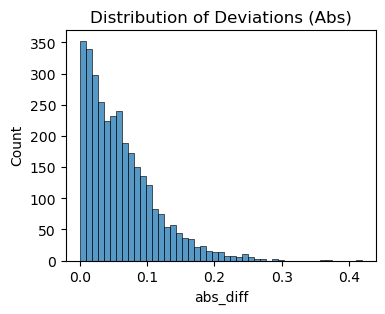

In [24]:
fig, ax = plt.subplots(figsize=(4,3))

sns.histplot(trial['abs_diff'])

plt.title("Distribution of Deviations (Abs)")
plt.show()

In [26]:
month_comparison = (
    pd.concat(
        [trial.groupby('month').apply(lambda x: log_loss(x['rearrange'], x['p1'])), 
         trial.groupby('month').apply(lambda x: log_loss(x['rearrange'], x['p2']))], axis=1)
    .rename(columns={0 : 'vegas', 1 : 'model'})
)

month_comparison['matches'] = trial.groupby('month').size()
month_comparison['vegas_edge'] = month_comparison['model'] - month_comparison['vegas']

month_comparison

,vegas,model,matches,vegas_edge
month,,,,
1,0.585957,0.597111,323,0.011154
2,0.576667,0.595960,414,0.019293
3,0.592668,0.589152,320,-0.003516
4,0.600460,0.594272,266,-0.006188
5,0.536844,0.541713,349,0.004869
6,0.546953,0.560475,332,0.013522
7,0.603837,0.618313,254,0.014476
8,0.579724,0.589407,419,0.009683
9,0.580719,0.591635,176,0.010916


In [36]:
cols = ['winner_name', 'loser_name', 'player_id', 'player_2_id', 'p1', 'p2', 'abs_diff', 'tourney_date', 'tourney_id']

In [37]:
trial[trial['abs_diff'] >= 0.15][cols]

,winner_name,loser_name,player_id,player_2_id,p1,p2,abs_diff,tourney_date,tourney_id
42442,Sebastian Korda,Soon Woo Kwon,126952.0,200624.0,0.574713,0.359593,0.215120,2021-01-04,2021-0499
42457,Roberto Quiroz,Ivo Karlovic,105933.0,103333.0,0.423729,0.583139,0.159410,2021-01-04,2021-0499
42460,Christian Harrison,Cristian Garin,106328.0,106426.0,0.625000,0.778787,0.153787,2021-01-04,2021-0499
42464,Christian Harrison,Gianluca Mager,106328.0,126149.0,0.595238,0.382764,0.212474,2021-01-04,2021-0499
42655,Miomir Kecmanovic,Soon Woo Kwon,126952.0,200175.0,0.598802,0.410509,0.188293,2021-02-01,2021-8998
...,...,...,...,...,...,...,...,...,...
50803,Ben Shelton,Alexei Popyrin,210097.0,200615.0,0.606061,0.365870,0.240191,2023-01-16,2023-580
50854,Maxime Cressy,Antoine Bellier,134472.0,202195.0,0.813008,0.661534,0.151474,2023-02-06,2023-0375
50861,Marton Fucsovics,Geoffrey Blancaneaux,144972.0,105916.0,0.746269,0.544301,0.201968,2023-02-06,2023-0375
50896,Emilio Gomez,Gabriel Diallo,209113.0,105877.0,0.534759,0.314596,0.220163,2023-02-06,2023-0424
